# Lab Report 2
## Group 3
## Caroline Kuntz 940915-1462
## Niklas Landsberg 940421-T857

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [2]:
#Assumptions
risk_free_rate=0.001

In [3]:
#Functions used for Global Minimum Variance portfolio

#1. Define portfolio return
def portfolio_return(weights,returns):
    return weights.T @ returns

#2. Define portfolio variance
def portfolio_risk(weights, cov_matrix):
    return(weights.T @ cov_matrix @ weights)**0.5


#3. Define minimimum risk
def minimize_risk(target_return, Expected_Return, cov):

    n= Expected_Return.shape[0]

    initial_guess=np.repeat(1/n,n)
    
    bounds=((0,1),)*n
    
    #Constraints
    return_is_target={
        'type':'eq',
        'args':(Expected_Return,),
        'fun':lambda weights, Expected_Return: target_return-portfolio_return(weights, Expected_Return)
    }
    
    weights_sum_to_1={
        'type':'eq',
        'fun':lambda weights:np.sum(weights)-1
    }
    
    results=minimize(portfolio_risk,
                     initial_guess,
                     args=(cov,),
                     method="SLSQP", 
                     constraints=(return_is_target,weights_sum_to_1),
                     bounds=bounds
                    )
    return results.x

#4. Define Maximum Sharpe Ratio
def maximum_sharpe_ratio(risk_free_rate, Expected_Return, cov):
    
    n=Expected_Return.shape[0]
    
    initial_guess=np.repeat(1/n,n)
    
    bounds=((0,1),)*n
    
    weights_sum_to_1={
        'type':'eq',
        'fun':lambda weights:np.sum(weights)-1
    }
    
    def neg_sharpe_ratio(weights, risk_free_rate, Expected_Return,cov):
        
        sharpe_ratio=(portfolio_return(weights, Expected_Return)-risk_free_rate)/portfolio_risk(weights, cov)
        return -1*sharpe_ratio
    
    results=minimize(neg_sharpe_ratio,
                     initial_guess,
                     args=(risk_free_rate, Expected_Return, cov,),
                     method="SLSQP",constraints=(weights_sum_to_1), 
                     bounds=bounds
                    )
    return results.x

#5. Draw the efficient frontier

def optimal_weights(n_points, Expected_Return,cov):
    
    target_returns=np.linspace(Expected_Return.min(), 
                               Expected_Return.max(), 
                               n_points
                              )
    
    weights=[minimize_risk(target_return, Expected_Return, cov) for target_return in target_returns]
    return weights

def plot_efficient_frontier(n_points,Expected_Return,cov):
    
    weights= optimal_weights(n_points, Expected_Return,cov)
    
    Returns=[portfolio_return(w,Expected_Return) for w in weights]
    
    Risk=[portfolio_risk(w,cov) for w in weights]
    
    efficient_frontier=pd.DataFrame({"Return":Returns, "Risk":Risk})
    return efficient_frontier.plot.scatter(x="Risk",y="Return")

#6. Minimum Global Variance Portfolio

def gmv(cov):
    n=cov.shape[0]
    
    return maximum_sharpe_ratio(0, np.repeat(1,n), cov)

### 1 – Read the 30 industry portfolios from the Kenneth French Website

In [4]:
#### Clean the data
data_return= pd.read_csv('industry_portfolios_30.csv',index_col=0)

data_return= data_return.replace(" ","")

data_return.dropna()

data_return.index=pd.to_datetime(data_return.index, format="%Y%m")

data_return.index=data_return.index.to_period('M')

data_return.columns=data_return.columns.str.strip()

data_return=data_return/100

data_return.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2019-08,0.0108,0.0619,-0.1104,-0.0588,-0.0459,0.0158,-0.0498,-0.0045,-0.0566,-0.0547,...,0.0043,-0.0213,-0.0359,-0.0296,-0.0687,-0.0234,-0.0012,0.0134,-0.0469,-0.0213
2019-09,0.0050,0.0162,0.0195,-0.0467,0.0139,0.0175,0.0914,-0.0054,0.0560,0.0741,...,0.0130,-0.0106,0.0436,0.0174,0.0054,0.0536,0.0096,-0.0249,0.0258,0.0219
2019-10,-0.0166,-0.0104,0.0810,0.0584,0.0135,-0.0072,-0.0218,0.0447,-0.0095,0.1062,...,0.0223,0.0188,0.0537,0.0000,0.0137,0.0245,0.0165,-0.0427,0.0329,0.0189
2019-11,0.0199,-0.0059,0.0552,0.0615,-0.0099,-0.0128,0.0467,0.0530,0.0382,-0.0224,...,0.0175,0.0503,0.0478,0.0312,0.0275,0.0441,0.0206,0.0282,0.0568,0.0424
2019-12,0.0358,0.0138,0.0322,0.0397,0.0323,0.0263,0.0768,0.0333,0.0135,-0.0342,...,0.0124,0.0179,0.0624,0.0217,-0.0024,0.0239,0.0121,0.0259,0.0259,0.0205


### 2- Select your opportunity set (simply choose a subset of assets that you are interested to invest in) 

In [5]:
Assets=['Chems','Rtail','Servs','Telcm']

In [6]:
data_return_period_1=data_return[Assets]

In [7]:
data_return_period_1.tail()

,Chems,Rtail,Servs,Telcm
2019-08,-0.0566,-0.0012,-0.0213,0.0043
2019-09,0.0560,0.0096,-0.0106,0.0130
2019-10,-0.0095,0.0165,0.0188,0.0223
2019-11,0.0382,0.0206,0.0503,0.0175
2019-12,0.0135,0.0121,0.0179,0.0124


### 4- Estimate the Expected Returns and Covariance Matrix for these set of assets using the data from Jan 2000 to Dec 2010. 

In [8]:
data_return_period_1=data_return[Assets].loc['2000-01':'2010-12']

In [9]:
data_return_period_1.tail()

,Chems,Rtail,Servs,Telcm
2010-08,-0.0011,-0.0418,-0.0526,-0.0223
2010-09,0.0997,0.1359,0.1162,0.0786
2010-10,0.0818,0.0132,0.0801,0.0481
2010-11,0.0084,0.0495,-0.0243,-0.0186
2010-12,0.0749,0.0350,0.0714,0.0671


In [10]:
Expected_Return_Period_1=data_return_period_1.mean()

Expected_Return_Period_1

Chems    0.008413
Rtail    0.003420
Servs   -0.000390
Telcm   -0.002809
dtype: float64

In [11]:
cov_period_1=data_return_period_1.cov()

cov_period_1

,Chems,Rtail,Servs,Telcm
Chems,0.004168,0.002382,0.002785,0.002480
Rtail,0.002382,0.002845,0.002476,0.002166
Servs,0.002785,0.002476,0.005338,0.003504
Telcm,0.002480,0.002166,0.003504,0.003702


### 5. Find the Minimum-Variance Portfolio using the data from Jan 2000 to Dec 2010.

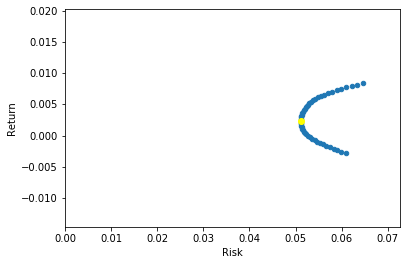

In [29]:
ax=plot_efficient_frontier(50,Expected_Return_Period_1.values,cov_period_1)
ax.set_xlim(left=0)

                                
weight_gmv=gmv(cov_period_1)
Return_gmv_period_1=portfolio_return(weight_gmv,Expected_Return_Period_1.values)
Risk_gmv_period_1=portfolio_risk(weight_gmv,cov_period_1)
                                
ax.plot([Risk_gmv_period_1],
        [Return_gmv_period_1],
        color="yellow",
        marker="o",linestyle="dashed",
       )

In [13]:
print(f'The portfolio\'s weights are {weight_gmv}')

The portfolio's weights are [0.11388332 0.61941995 0.         0.26669673]


### 6. What is the Minimum-Variance Portfolio Return and Variance using the estimated values from Jan 2000 to Dec 2010. 

In [14]:
print(f'The portfolio\'s return in the first period is {Return_gmv_period_1}')

The portfolio's return in the first period is 0.0023276089981688402


In [15]:
print(f'The portfolio\'s volatility in the first period is {Risk_gmv_period_1}')

The portfolio's volatility in the first period is 0.05110085732720375


### 7. Next, let’s invest out-of-sample: Invest based on the estimated portfolio weights of Minimum-Variance Portfolio from Jan 2011 to Dec 2018. What is the Portfolio Return, Variance and Sharpe Ratio.
 

In [16]:
data_return_period_2=data_return[Assets].loc['2011-01':'2018-12']

data_return_period_2

,Chems,Rtail,Servs,Telcm
2011-01,0.0160,-0.0128,0.0248,0.0005
2011-02,0.0492,0.0138,0.0247,0.0759
2011-03,0.0201,0.0048,0.0007,0.0177
2011-04,0.0448,0.0520,0.0264,0.0341
2011-05,-0.0376,0.0021,-0.0228,0.0077
...,...,...,...,...
2018-08,0.0001,0.0916,0.0529,0.0294
2018-09,-0.0287,0.0061,-0.0043,0.0175
2018-10,-0.1250,-0.1026,-0.0923,-0.0053
2018-11,0.0496,0.0159,0.0128,0.0253


In [17]:
Expected_Return_Period_2=data_return_period_2.mean()

Expected_Return_Period_2

Chems    0.008747
Rtail    0.012344
Servs    0.012007
Telcm    0.009407
dtype: float64

In [18]:
cov_period_2=data_return_period_2.cov()

cov_period_2

,Chems,Rtail,Servs,Telcm
Chems,0.002696,0.001226,0.001561,0.001161
Rtail,0.001226,0.001455,0.001090,0.000873
Servs,0.001561,0.001090,0.001549,0.000847
Telcm,0.001161,0.000873,0.000847,0.001367


In [19]:
Return_gmv_period_2=portfolio_return(weight_gmv,Expected_Return_Period_2.values)

print(f'The portfolio\'s return in the second period is {Return_gmv_period_2}')

The portfolio's return in the second period is 0.011150982110405784


In [20]:
Risk_gmv_period_2=portfolio_risk(weight_gmv,cov_period_2)

print(f'The portfolio\'s volatility in the second period is {Risk_gmv_period_2}')

The portfolio's volatility in the second period is 0.03496034458954588


In [21]:
sharpe_ratio_gmv = (Return_gmv_period_2 - risk_free_rate)/Risk_gmv_period_2

print(f'The portfolio\'s sharpe ratio in the second period is {sharpe_ratio_gmv}')

The portfolio's sharpe ratio in the second period is 0.2903570382267116


### 8. In the same period of Jan 2011 to Dec 2018, invest using a naïve 1/N rule. Compute the Portfolio Return, Variance and Sharpe Ratio. 

In [22]:
number_of_assets=len(Assets)

number_of_assets

4

In [23]:
weight_ew=np.repeat(1/number_of_assets,number_of_assets)

In [24]:
weight_ew

array([0.25, 0.25, 0.25, 0.25])

In [25]:
Return_ew_period_2=portfolio_return(weight_ew, Expected_Return_Period_2.values)

print(f'The equally weighted portfolio\'s return in the second period is {Return_ew_period_2}')

The equally weighted portfolio's return in the second period is 0.010626302083333332


In [26]:
Risk_ew_period_2=portfolio_risk(weight_ew,cov_period_2)

print(f'The equally weighted portfolio\'s volatility in the second period is {Risk_ew_period_2}')

The equally weighted portfolio's volatility in the second period is 0.03586751524154583


In [27]:
sharpe_ratio_ew = (Return_ew_period_2 - risk_free_rate)/Risk_ew_period_2

print(f'The equally weighted portfolio\'s sharpe ratio in the second period is {sharpe_ratio_ew}')

The equally weighted portfolio's sharpe ratio in the second period is 0.2683849722654626


### 9. Based on the Sharpe Ratios of Minimum Variance Portfolio and 1/N rule, which strategy you pick? 

In [28]:
if sharpe_ratio_ew < sharpe_ratio_gmv:
    print(f'''
    The global minimum variance portfolio is prefered. 
    It\'s sharpe ratio is {sharpe_ratio_gmv}.
    The sharpe ratio is {sharpe_ratio_gmv-sharpe_ratio_ew} higher.''')
else:
    print(f'''
    The equally weighted portfolio is prefered. 
    It\'s sharpe ratio is {sharpe_ratio_ew}.
    The sharpe ratio is {sharpe_ratio_ew-sharpe_ratio_gmv} higher.''')


    The global minimum variance portfolio is prefered. 
    It's sharpe ratio is 0.2903570382267116.
    The sharpe ratio is 0.02197206596124901 higher.
